# Generate Plots for Performance and Classified Data

## Imports

In [50]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from collections import defaultdict
sns.set_theme()

## Plotting Functions

In [64]:
def plot(data: pd.DataFrame, title: str | None = None, ax: plt.Axes | None = None) -> None:
    if ax is None:
        _, ax = plt.subplots()
    sns.lineplot(ax=ax, data=data, x="date", y="num_nontoxic", label="Nontoxic")
    sns.lineplot(ax=ax, data=data, x="date", y="num_toxic", label="Toxic")
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Count")

def raw_plot(path: str, title: str | None = None, ax: plt.Axes | None = None) -> None:
    data = pd.read_csv(path)
    data["date"] = pd.to_datetime(data["date"])
    plot(data, title=title, ax=ax)

def smooth_plot(path: str, frac: float = 0.01, title: str | None = None, ax: plt.Axes | None = None) -> None:
    data = pd.read_csv(path)
    data["date"] = pd.to_datetime(data["date"])
    data["num_nontoxic"] = sm.nonparametric.lowess(data["num_nontoxic"], data["date"], frac=frac)[:,1][::-1]
    data["num_toxic"] = sm.nonparametric.lowess(data["num_toxic"], data["date"], frac=frac)[:,1][::-1]
    plot(data, title=title, ax=ax)

def performance_plot(path: str) -> None:
    plt.figure()
    with open(path) as log_file:
        log = json.load(log_file)["log_history"]
        epochs = defaultdict(list)
        for item in log:
            try:
                loss = item["eval_loss"]
                accuracy = item["eval_accuracy"]
                precision = item["eval_precision"]
                recall = item["eval_recall"]
                f1 = item["eval_f1"]
            except KeyError:
                continue

            epochs[item["epoch"]].append(loss)
            epochs[item["epoch"]].append(accuracy)
            epochs[item["epoch"]].append(precision)
            epochs[item["epoch"]].append(recall)
            epochs[item["epoch"]].append(f1)
        data = np.ndarray((len(epochs), 6))
        for epoch, metrics in epochs.items():
            data[int(epoch - 1),:] = [epoch, *metrics]
        data = pd.DataFrame(data, columns=["Epoch", "Loss", "Accuracy", "Precision", "Recall", "F1"])
    sns.lineplot(data=pd.melt(data, ["Epoch"], var_name="Metric" ,value_name="Value"), x="Epoch", y="Value", hue="Metric")

def scrape_plot(groups: list[str, str]) -> None:
    counts = []
    for path, group in groups:
        data = pd.read_csv(path)
        count = data["num_nontoxic"].sum()
        count += data["num_toxic"].sum()
        counts.append([group, count])
    counts = pd.DataFrame(data=counts, columns=["Minority Group", "Count"])
    ax = sns.barplot(data=counts, x="Minority Group", y="Count")
    ax.set_yscale("log")
    ax.bar_label(ax.containers[0])
    

## Scraping Results

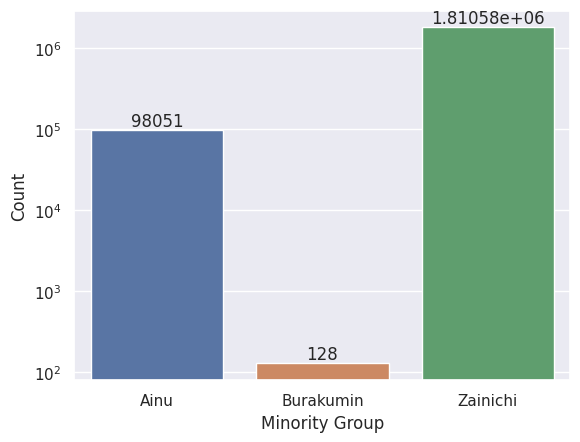

In [33]:
datasets = [
    ["./data/twitter_ainu_since_2018_by_date.csv", "Ainu"],
    ["./data/twitter_burakumin_since_2018_by_date.csv", "Burakumin"],
    ["./data/twitter_zainichi_since_2018_by_date.csv", "Zainichi"]
]
scrape_plot(datasets)

## Performance Plot

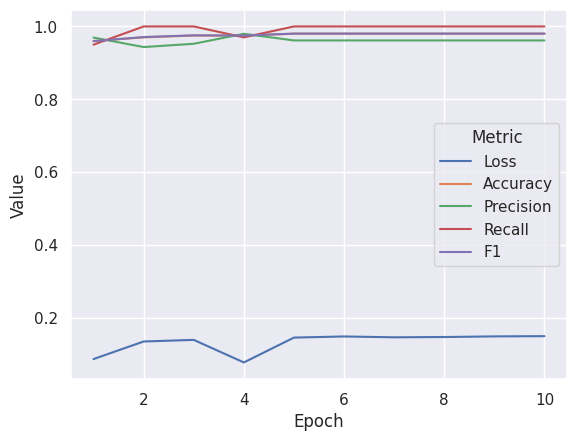

In [62]:
performance_plot("./models/checkpoint-1000/trainer_state.json")

## Timeseries Plots

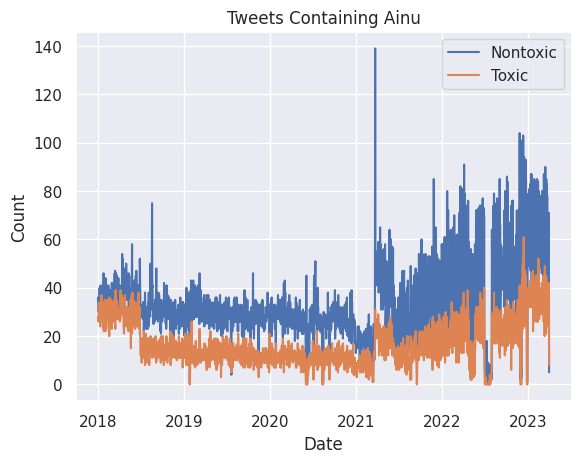

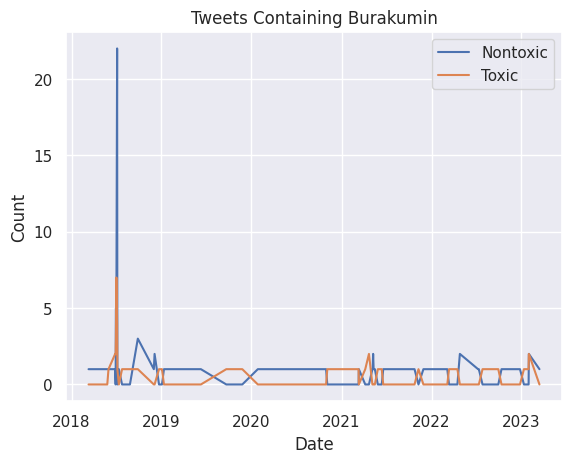

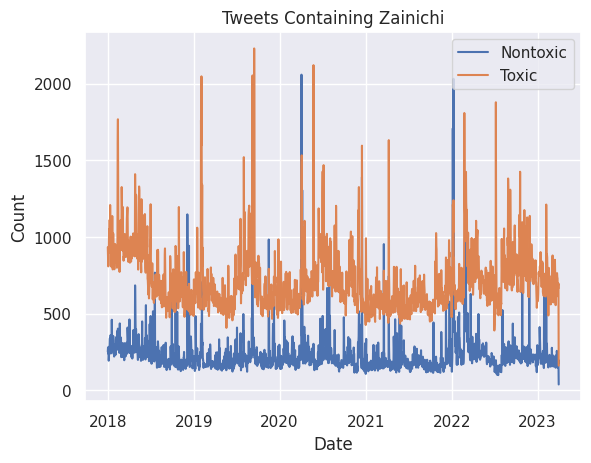

In [65]:
raw_plot("./data/twitter_ainu_since_2018_by_date.csv", title="Tweets Containing Ainu")
raw_plot("./data/twitter_burakumin_since_2018_by_date.csv", title="Tweets Containing Burakumin")
raw_plot("./data/twitter_zainichi_since_2018_by_date.csv", title="Tweets Containing Zainichi")

## Smoothed Timeseries Plots

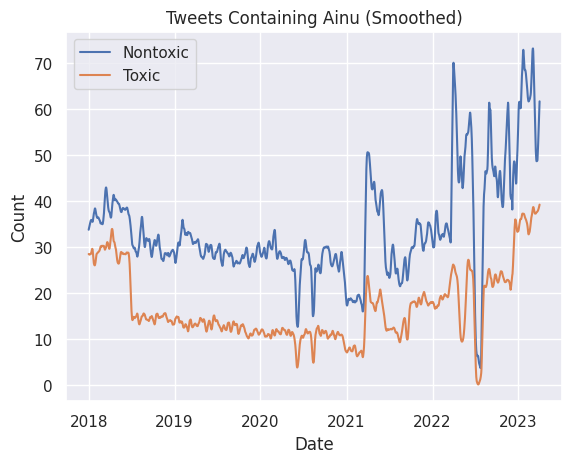

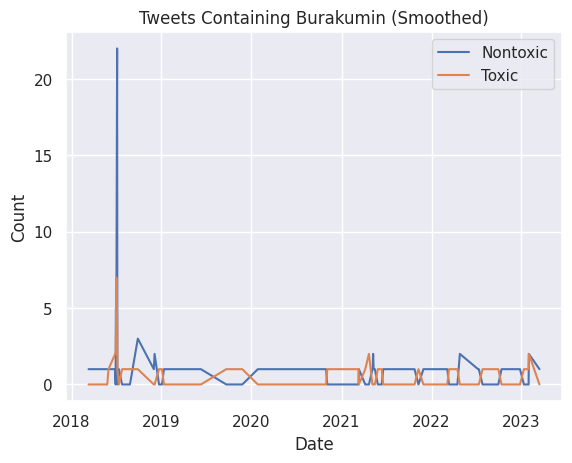

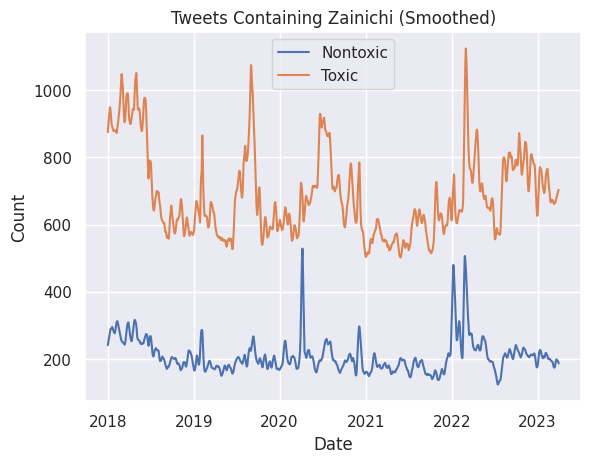

In [66]:
smooth_plot("./data/twitter_ainu_since_2018_by_date.csv", title="Tweets Containing Ainu (Smoothed)")
smooth_plot("./data/twitter_burakumin_since_2018_by_date.csv", title="Tweets Containing Burakumin (Smoothed)")
smooth_plot("./data/twitter_zainichi_since_2018_by_date.csv", title="Tweets Containing Zainichi (Smoothed)")

## Single Timeseries Plot

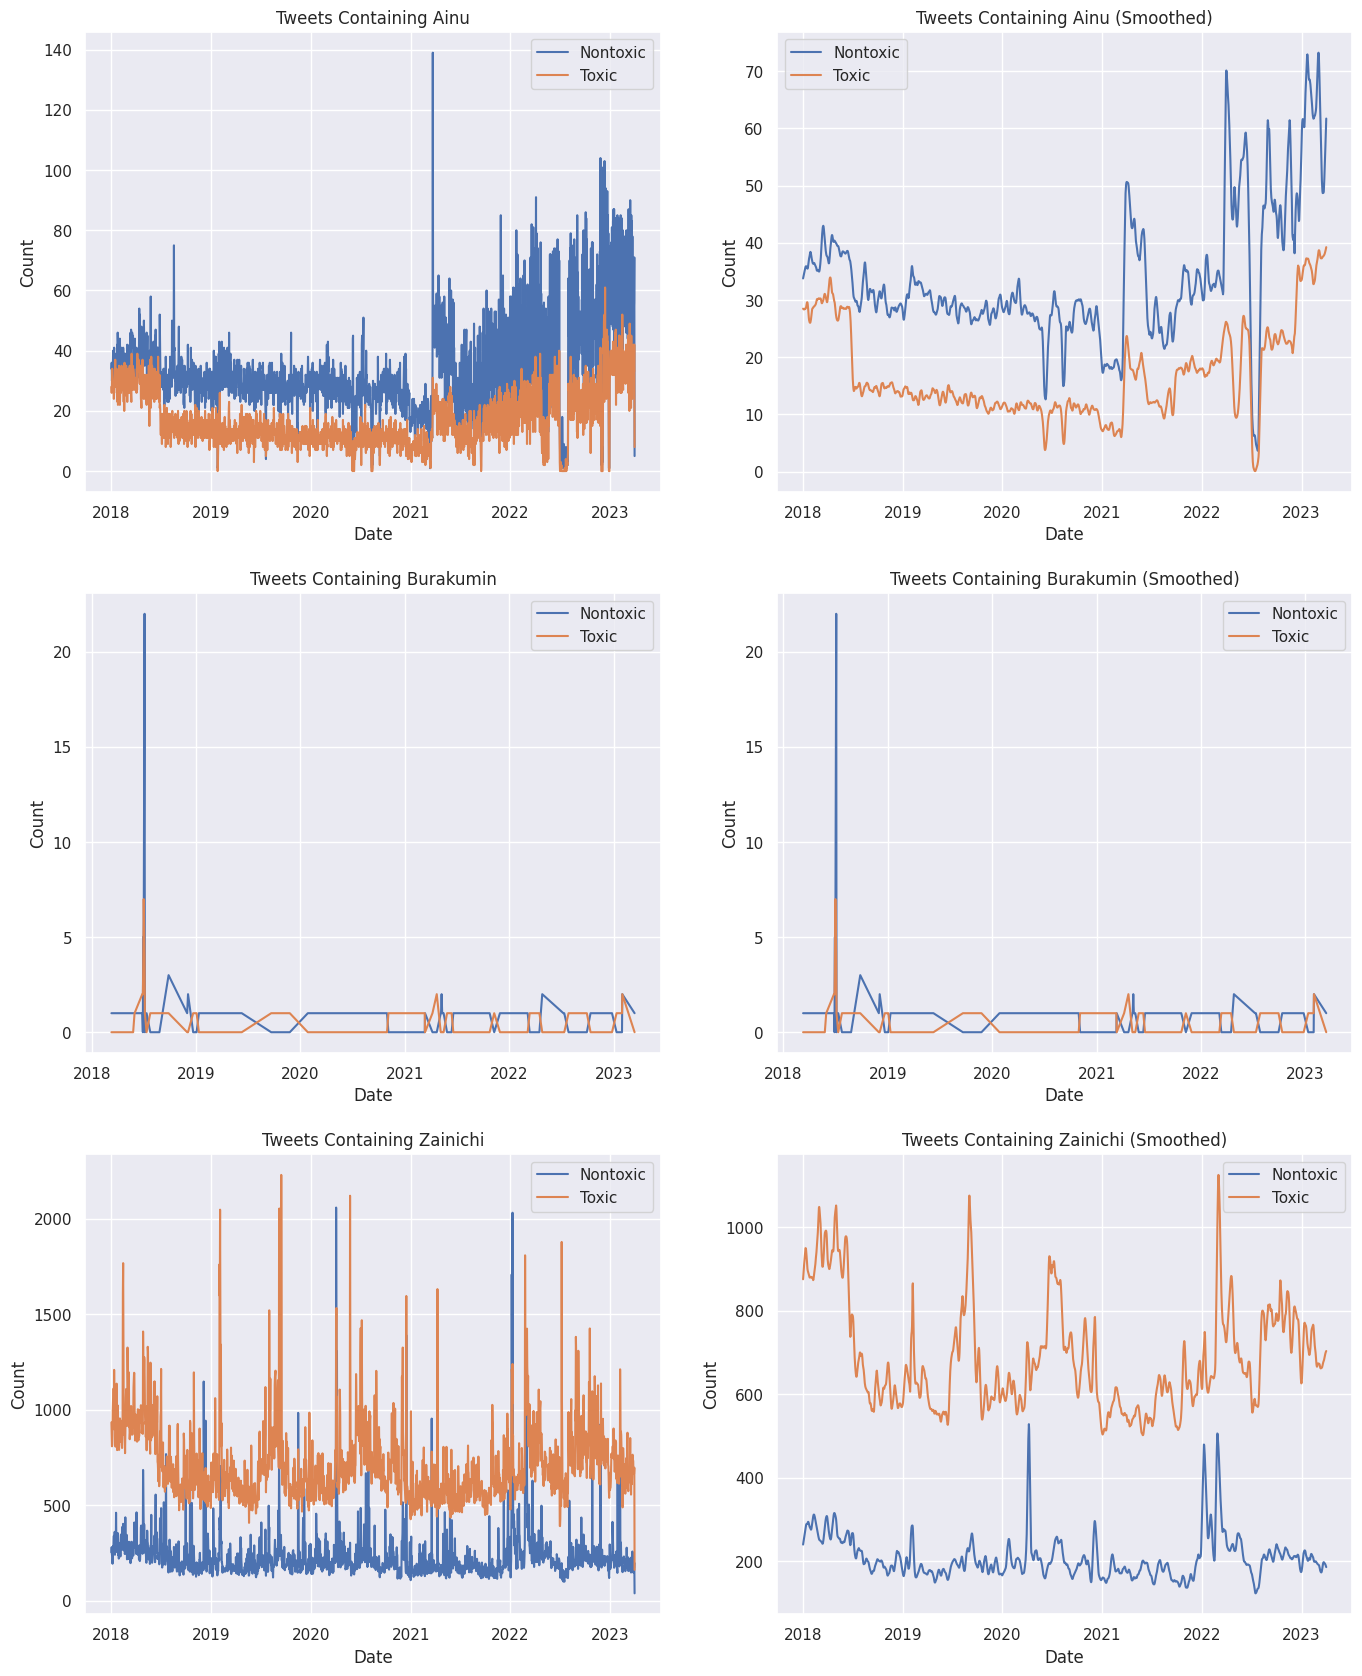

In [81]:
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(14.5, 17.5)
fig.tight_layout(pad=4.0)
raw_plot("./data/twitter_ainu_since_2018_by_date.csv", title="Tweets Containing Ainu", ax=axes[0][0])
raw_plot("./data/twitter_burakumin_since_2018_by_date.csv", title="Tweets Containing Burakumin", ax=axes[1][0])
raw_plot("./data/twitter_zainichi_since_2018_by_date.csv", title="Tweets Containing Zainichi", ax=axes[2][0])
smooth_plot("./data/twitter_ainu_since_2018_by_date.csv", title="Tweets Containing Ainu (Smoothed)", ax=axes[0][1])
smooth_plot("./data/twitter_burakumin_since_2018_by_date.csv", title="Tweets Containing Burakumin (Smoothed)", ax=axes[1][1])
smooth_plot("./data/twitter_zainichi_since_2018_by_date.csv", title="Tweets Containing Zainichi (Smoothed)", ax=axes[2][1])